In [1]:
%matplotlib inline

In [2]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import multiprocessing as mp
mp.set_start_method('spawn', force=True)

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import math
import pandas as pd
from pandas import Timestamp
import numpy as np

import glob
import datetime as dt
from datetime import datetime

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history

import json
import matplotlib.pyplot as plt
from IPython.display import display, clear_output, update_display, HTML

import io
import os
import json
import contextlib
from tqdm.auto import tqdm

pd.set_option('display.max_columns', None)

import os # Force fully single-threaded
os.environ["OMP_NUM_THREADS"]    = "1"
os.environ["MKL_NUM_THREADS"]    = "1"
os.environ["NUMEXPR_NUM_THREADS"]= "1"

Running process_splits …
Reading data from intraday_stocks/AAPL_20040102_20250618.csv
Plotting original data...


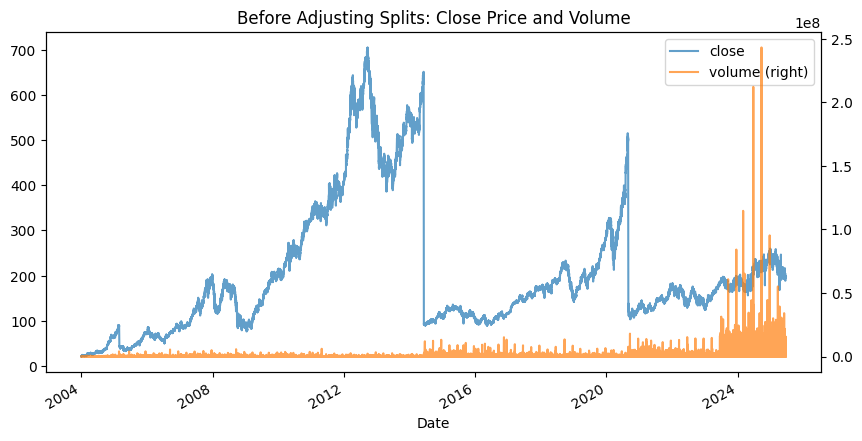

Detected forward split on 2014-06-09 08:00:00 with factor 7 (ratio: 0.1431)
Detected forward split on 2020-08-31 08:00:00 with factor 4 (ratio: 0.2510)
Splits detected. Plotting adjusted data...


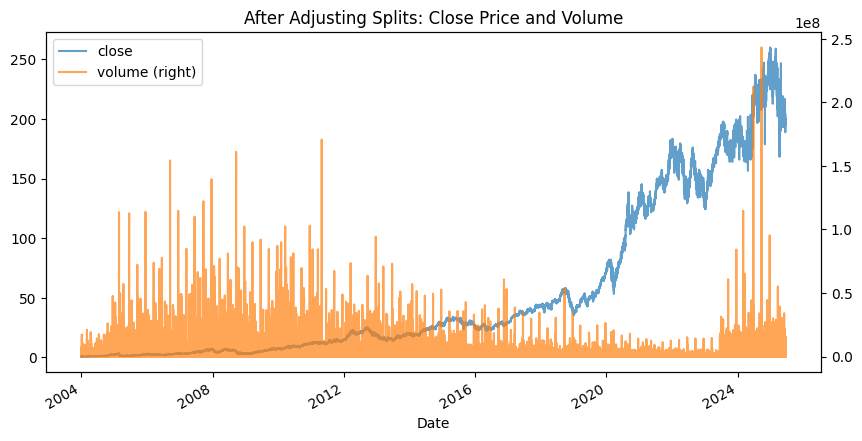

Running prepare_interpolate_data …
prepare_interpolate_data: removed 0 duplicate timestamps.
[process_splits] Saved processed data to: dfs_training/AAPL_1_base.csv


,open,high,low,close,volume,ask,bid
2004-01-02 11:30:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764514,0.764057
2004-01-02 11:31:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764514,0.764057
2004-01-02 11:32:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764514,0.764057
2004-01-02 11:33:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764514,0.764057
2004-01-02 11:34:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764514,0.764057
...,...,...,...,...,...,...,...
2025-06-18 20:56:00,196.680000,196.860000,196.630000,196.815000,385695.0,196.874000,196.756000
2025-06-18 20:57:00,196.810000,196.940000,196.560000,196.675000,460630.0,196.734000,196.616000
2025-06-18 20:58:00,196.675000,196.740000,196.630000,196.670000,525245.0,196.729000,196.611000
2025-06-18 20:59:00,196.680000,196.750000,196.240000,196.240000,2075503.0,196.298900,196.181100


In [3]:
ticker         = params.ticker
save_path      = params.save_path
             
n_trials = 300
n_jobs = 1

base_csv = params.base_csv

print(f"Running process_splits …")
df_raw = trades.process_splits(
    folder                   = params.stocks_folder,
    ticker                   = ticker,
    bidasktoclose_spread     = params.bidasktoclose_spread
)

# Once‐only minute grid build and interpolation
print(f"Running prepare_interpolate_data …")
df = trades.prepare_interpolate_data(
    df                    = df_raw,
    regular_start_shifted = params.regular_start_shifted,
    regular_start         = params.regular_start,
    regular_end           = params.regular_end
)

# Persist to base CSV and return
df.to_csv(base_csv)
print(f"[process_splits] Saved processed data to: {base_csv}")

# df is now guaranteed to be the split‐adjusted, minute‐aligned DataFrame
df


In [4]:
def optimization_function(
    df,
    look_back,
    min_prof_thr, 
    max_down_prop, 
    gain_tightening_factor, 
    merging_retracement_thr, 
    merging_time_gap_thr, 
    smooth_win_sig, 
    pre_entry_decay, 
    short_penalty,
    trailing_stop_thresh,
    buy_threshold
) -> float:
    """
    1) Compute median‐profit reference for this trial's thresholds.
    2) Run full backtest → one Strategy Return ($) per calendar day.
    3) Compute:
        - total_pnl       : sum of daily P&L across all trading days
        - avg_daily_pnl   : total_pnl divided by # of unique trading days
    4) Print both, return avg_daily_pnl to Optuna.
    """
    
    regular_start_pred = dt.time(*divmod(
        params.regular_start.hour * 60 + params.regular_start.minute - look_back,
        60
    ))
    regular_start_shifted = dt.time(*divmod(
        params.regular_start.hour * 60 + params.regular_start.minute - look_back*2,
        60
    ))

    # A) dynamic reference profit
    ref_profit = trades.compute_global_ref_profit(
        df,
        min_prof_thr            = min_prof_thr,
        max_down_prop           = max_down_prop,
        gain_tightening_factor  = gain_tightening_factor,
        merging_retracement_thr = merging_retracement_thr,
        merging_time_gap_thr    = merging_time_gap_thr,
        regular_start_pred      = regular_start_pred,
        regular_end             = params.regular_end
    )

    # B) run backtest, collect one return per day
    simulation = trades.run_trading_pipeline(
        df                       = df,
        col_signal               = 'signal_smooth',
        col_action               = 'signal_action',
        ref_profit               = ref_profit,
        smooth_win_sig           = smooth_win_sig,
        pre_entry_decay          = pre_entry_decay,
        short_penalty            = short_penalty,
        trailing_stop_thresh     = trailing_stop_thresh,
        buy_threshold            = buy_threshold,
        regular_start_shifted    = regular_start_shifted
    )

    # C) extract per-day stats
    per_day_stats = [stats for _, (_, _, stats) in simulation.items()]

    # free up every df_sim and trades_list before proceeding
    for _, (df_sim, trades_list, _) in simulation.items():
        del df_sim, trades_list
    del simulation
    gc.collect()

    # — use all trading days for the daily-P&L average —
    num_days      = trades.count_trading_days(df, params.regular_start, params.regular_end)
    daily_returns = [s["Strategy Return ($)"] for s in per_day_stats]
    total_pnl     = float(np.sum(daily_returns))
    avg_daily_pnl = total_pnl / num_days if num_days else 0.0

    # D) compute trade-level metrics on days with at least one trade
    trade_days_stats = [
        s for s in per_day_stats
        if s.get("Trades Returns ($)")
    ]
    total_trades  = sum(len(s["Trades Returns ($)"]) for s in trade_days_stats)
    avg_per_trade = total_pnl / total_trades if total_trades else 0.0

    # E) print detailed results
    print(f"→ Total return across {num_days} trading days: ${total_pnl:.2f}")
    print(f"→ Avg daily return (all days)          : ${avg_daily_pnl:.4f}")
    print(f"→ Total trades                          : {total_trades}")
    print(f"→ Avg return per trade                  : ${avg_per_trade:.4f}\n")

    return avg_daily_pnl


In [5]:
# calculate all possible look_backs, and create a list to use in the objective function,
# considering that it must be less than half time difference between regular_start and the first available timestamp

# 1) grab first timestamp’s time
first_ts = df.index.min()          # e.g. Timestamp('2004-01-02 11:30:00')
first_time = first_ts.time()       # → datetime.time(11, 30)

# 2) convert to minutes since midnight
first_minutes   = first_time.hour * 60 + first_time.minute
start_minutes   = params.regular_start.hour * 60 + params.regular_start.minute

# 3) compute half the interval
diff_minutes  = start_minutes - first_minutes         # e.g. 14:30 − 11:30 = 330
half_minutes  = diff_minutes / 2                      # → 165.0

# 4) how many full 30-min chunks fit below half_minutes?
n_steps = int(half_minutes // 30)                     # floor(165/30) = 5

# 5) build your list of multiples
look_backs = [30 * i for i in range(1, n_steps + 1)]   # → [30, 60, 90, 120, 150]

print(look_backs)


def objective(trial):
    hyperpars = {
        "look_back"               : trial.suggest_categorical("look_back", look_backs),
        "min_prof_thr"            : trial.suggest_float("min_prof_thr", 0.1, 0.7),
        "max_down_prop"           : trial.suggest_float("max_down_prop", 0.1, 0.9),
        "gain_tightening_factor"  : trial.suggest_float("gain_tightening_factor", 0.1, 0.9),
        "merging_retracement_thr" : trial.suggest_float("merging_retracement_thr", 0.1, 0.7),
        "merging_time_gap_thr"    : trial.suggest_float("merging_time_gap_thr", 0.1, 0.7),
        "smooth_win_sig"          : trial.suggest_categorical("smooth_win_sig", [1,2,3,5,10,15,20,30]),
        "pre_entry_decay"         : trial.suggest_float("pre_entry_decay", 0.1, 0.7),
        "short_penalty"           : trial.suggest_float("short_penalty", 0.01, 0.5),
        "trailing_stop_thresh"    : trial.suggest_float("trailing_stop_thresh", 0.01, 0.5),
        "buy_threshold"           : trial.suggest_float("buy_threshold", 0.05, 0.5),
    }

    print('---------------------------------------------------')
    #    This will print Total P&L and Average Daily P&L, and return `avg_daily_pnl` for Optuna to maximize.
    avg_daily_pnl = optimization_function(df=df, **hyperpars)

    return avg_daily_pnl


[30, 60, 90]


[I 2025-08-05 21:07:34,167] A new study created in RDB with name: no-name-e37e8372-eca3-4874-9034-1be902d3bc05


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-05 21:10:01,279] Trial 0 finished with value: 0.37945259259259256 and parameters: {'look_back': 30, 'min_prof_thr': 0.20319057834784185, 'max_down_prop': 0.7855008310544108, 'gain_tightening_factor': 0.5936872605576402, 'merging_retracement_thr': 0.45291431823294137, 'merging_time_gap_thr': 0.266387394308616, 'smooth_win_sig': 2, 'pre_entry_decay': 0.31684226267674287, 'short_penalty': 0.22288061637193746, 'trailing_stop_thresh': 0.01370354828863831, 'buy_threshold': 0.43165946690602497}. Best is trial 0 with value: 0.37945259259259256.


→ Total return across 5400 trading days: $2049.04
→ Avg daily return (all days)          : $0.3795
→ Total trades                          : 4702
→ Avg return per trade                  : $0.4358



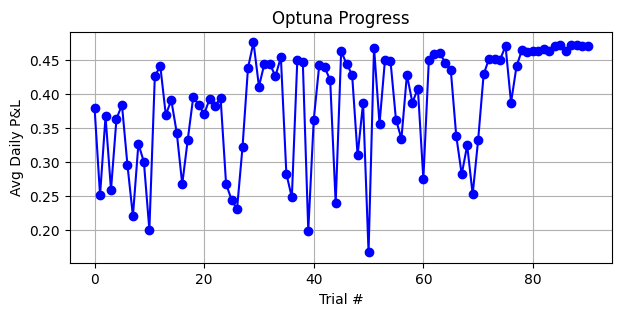

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-05 21:13:01,086] Trial 1 finished with value: 0.25079481481481486 and parameters: {'look_back': 90, 'min_prof_thr': 0.3115470216819663, 'max_down_prop': 0.37616393727595687, 'gain_tightening_factor': 0.10056856556922905, 'merging_retracement_thr': 0.4666478799605034, 'merging_time_gap_thr': 0.3893346303839821, 'smooth_win_sig': 15, 'pre_entry_decay': 0.3426776178333901, 'short_penalty': 0.47877981801503694, 'trailing_stop_thresh': 0.1049008365384834, 'buy_threshold': 0.35598242266512264}. Best is trial 0 with value: 0.37945259259259256.


→ Total return across 5400 trading days: $1354.29
→ Avg daily return (all days)          : $0.2508
→ Total trades                          : 1938
→ Avg return per trade                  : $0.6988

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-05 21:15:31,725] Trial 2 finished with value: 0.3666831481481481 and parameters: {'look_back': 30, 'min_prof_thr': 0.12263847831469749, 'max_down_prop': 0.8281619711719176, 'gain_tightening_factor': 0.8375536852502677, 'merging_retracement_thr': 0.32411646613690787, 'merging_time_gap_thr': 0.18570410010404098, 'smooth_win_sig': 2, 'pre_entry_decay': 0.3167253769081849, 'short_penalty': 0.3770856290225144, 'trailing_stop_thresh': 0.13446232554791127, 'buy_threshold': 0.4932756740053526}. Best is trial 0 with value: 0.37945259259259256.


→ Total return across 5400 trading days: $1980.09
→ Avg daily return (all days)          : $0.3667
→ Total trades                          : 3046
→ Avg return per trade                  : $0.6501

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-05 21:17:58,728] Trial 3 finished with value: 0.2585862962962963 and parameters: {'look_back': 30, 'min_prof_thr': 0.2523018257746281, 'max_down_prop': 0.5486912568691534, 'gain_tightening_factor': 0.7170849832669063, 'merging_retracement_thr': 0.3495058562907327, 'merging_time_gap_thr': 0.33261965713912245, 'smooth_win_sig': 15, 'pre_entry_decay': 0.2816043285131811, 'short_penalty': 0.20970367874221185, 'trailing_stop_thresh': 0.40298083569814186, 'buy_threshold': 0.4410237237374578}. Best is trial 0 with value: 0.37945259259259256.


→ Total return across 5400 trading days: $1396.37
→ Avg daily return (all days)          : $0.2586
→ Total trades                          : 1790
→ Avg return per trade                  : $0.7801

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-05 21:21:02,122] Trial 4 finished with value: 0.36342018518518515 and parameters: {'look_back': 90, 'min_prof_thr': 0.3162223607606365, 'max_down_prop': 0.15760800224775143, 'gain_tightening_factor': 0.6643553477349595, 'merging_retracement_thr': 0.1825290469161145, 'merging_time_gap_thr': 0.42052622626462544, 'smooth_win_sig': 2, 'pre_entry_decay': 0.5650115178458527, 'short_penalty': 0.1400038038941455, 'trailing_stop_thresh': 0.2740958042918116, 'buy_threshold': 0.36107761665294646}. Best is trial 0 with value: 0.37945259259259256.


→ Total return across 5400 trading days: $1962.47
→ Avg daily return (all days)          : $0.3634
→ Total trades                          : 3135
→ Avg return per trade                  : $0.6260

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-05 21:23:59,048] Trial 5 finished with value: 0.3835585185185185 and parameters: {'look_back': 60, 'min_prof_thr': 0.5182586775102765, 'max_down_prop': 0.6952017615666044, 'gain_tightening_factor': 0.24399063101734175, 'merging_retracement_thr': 0.19997272412782763, 'merging_time_gap_thr': 0.4176036541347615, 'smooth_win_sig': 3, 'pre_entry_decay': 0.6289565554345864, 'short_penalty': 0.3026701356937559, 'trailing_stop_thresh': 0.10886619450886773, 'buy_threshold': 0.13897136985954198}. Best is trial 5 with value: 0.3835585185185185.


→ Total return across 5400 trading days: $2071.22
→ Avg daily return (all days)          : $0.3836
→ Total trades                          : 4155
→ Avg return per trade                  : $0.4985

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-05 21:28:14,434] Trial 6 finished with value: 0.2953072222222222 and parameters: {'look_back': 30, 'min_prof_thr': 0.13776676869832688, 'max_down_prop': 0.10119241045736241, 'gain_tightening_factor': 0.558462799457093, 'merging_retracement_thr': 0.5861070128607524, 'merging_time_gap_thr': 0.275986382332256, 'smooth_win_sig': 3, 'pre_entry_decay': 0.39859212921940856, 'short_penalty': 0.22677441539377027, 'trailing_stop_thresh': 0.3233199156105506, 'buy_threshold': 0.3110489174655631}. Best is trial 5 with value: 0.3835585185185185.


→ Total return across 5400 trading days: $1594.66
→ Avg daily return (all days)          : $0.2953
→ Total trades                          : 3086
→ Avg return per trade                  : $0.5167

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-05 21:32:47,812] Trial 7 finished with value: 0.21991703703703705 and parameters: {'look_back': 30, 'min_prof_thr': 0.6868744165838776, 'max_down_prop': 0.5845941356594232, 'gain_tightening_factor': 0.5039677487493911, 'merging_retracement_thr': 0.3713335481503294, 'merging_time_gap_thr': 0.5817063092733796, 'smooth_win_sig': 30, 'pre_entry_decay': 0.6111133884592647, 'short_penalty': 0.27993411361618864, 'trailing_stop_thresh': 0.3704479900003815, 'buy_threshold': 0.3913353304583119}. Best is trial 5 with value: 0.3835585185185185.


→ Total return across 5400 trading days: $1187.55
→ Avg daily return (all days)          : $0.2199
→ Total trades                          : 1074
→ Avg return per trade                  : $1.1057

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-05 21:38:03,982] Trial 8 finished with value: 0.32629518518518524 and parameters: {'look_back': 90, 'min_prof_thr': 0.4342110712545423, 'max_down_prop': 0.6920210325400322, 'gain_tightening_factor': 0.25255069891682413, 'merging_retracement_thr': 0.5347688875193649, 'merging_time_gap_thr': 0.3572139922823092, 'smooth_win_sig': 2, 'pre_entry_decay': 0.32540851862347697, 'short_penalty': 0.08364480184178882, 'trailing_stop_thresh': 0.33039090270912214, 'buy_threshold': 0.24932998135132506}. Best is trial 5 with value: 0.3835585185185185.


→ Total return across 5400 trading days: $1761.99
→ Avg daily return (all days)          : $0.3263
→ Total trades                          : 2755
→ Avg return per trade                  : $0.6396

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-05 21:42:30,056] Trial 9 finished with value: 0.2997812962962963 and parameters: {'look_back': 60, 'min_prof_thr': 0.37020671681734485, 'max_down_prop': 0.13491573458754422, 'gain_tightening_factor': 0.5260495573402627, 'merging_retracement_thr': 0.5183886012031055, 'merging_time_gap_thr': 0.45026220514587123, 'smooth_win_sig': 15, 'pre_entry_decay': 0.5578191386262394, 'short_penalty': 0.04045008039927896, 'trailing_stop_thresh': 0.2291104552327051, 'buy_threshold': 0.33268004950286717}. Best is trial 5 with value: 0.3835585185185185.


→ Total return across 5400 trading days: $1618.82
→ Avg daily return (all days)          : $0.2998
→ Total trades                          : 2712
→ Avg return per trade                  : $0.5969

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-05 21:47:09,646] Trial 10 finished with value: 0.1996777777777778 and parameters: {'look_back': 60, 'min_prof_thr': 0.5211747004868655, 'max_down_prop': 0.35574192600504967, 'gain_tightening_factor': 0.33597456861754005, 'merging_retracement_thr': 0.1242213992869263, 'merging_time_gap_thr': 0.6252677779785885, 'smooth_win_sig': 3, 'pre_entry_decay': 0.1289691012050928, 'short_penalty': 0.3572637282222553, 'trailing_stop_thresh': 0.49637510684660535, 'buy_threshold': 0.09331223385182415}. Best is trial 5 with value: 0.3835585185185185.


→ Total return across 5400 trading days: $1078.26
→ Avg daily return (all days)          : $0.1997
→ Total trades                          : 3016
→ Avg return per trade                  : $0.3575

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-05 21:51:52,514] Trial 11 finished with value: 0.42638314814814815 and parameters: {'look_back': 60, 'min_prof_thr': 0.5564751340090639, 'max_down_prop': 0.8569568391343216, 'gain_tightening_factor': 0.3066073369941777, 'merging_retracement_thr': 0.24037664424263916, 'merging_time_gap_thr': 0.15291024425565075, 'smooth_win_sig': 1, 'pre_entry_decay': 0.6731421887767954, 'short_penalty': 0.3164710033821284, 'trailing_stop_thresh': 0.011016213600907585, 'buy_threshold': 0.18114917963357102}. Best is trial 11 with value: 0.42638314814814815.


→ Total return across 5400 trading days: $2302.47
→ Avg daily return (all days)          : $0.4264
→ Total trades                          : 5120
→ Avg return per trade                  : $0.4497

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-05 21:56:38,966] Trial 12 finished with value: 0.44070814814814807 and parameters: {'look_back': 60, 'min_prof_thr': 0.5756323208207699, 'max_down_prop': 0.870095253553203, 'gain_tightening_factor': 0.3430781562988541, 'merging_retracement_thr': 0.24038009139752645, 'merging_time_gap_thr': 0.1572798944343659, 'smooth_win_sig': 1, 'pre_entry_decay': 0.6831324128054186, 'short_penalty': 0.34909825582299586, 'trailing_stop_thresh': 0.015405856285685776, 'buy_threshold': 0.15614778842564783}. Best is trial 12 with value: 0.44070814814814807.


→ Total return across 5400 trading days: $2379.82
→ Avg daily return (all days)          : $0.4407
→ Total trades                          : 5361
→ Avg return per trade                  : $0.4439

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-05 22:01:19,350] Trial 13 finished with value: 0.3689577777777778 and parameters: {'look_back': 60, 'min_prof_thr': 0.6596200126510865, 'max_down_prop': 0.8885575531091211, 'gain_tightening_factor': 0.3663982415695787, 'merging_retracement_thr': 0.2417252387754548, 'merging_time_gap_thr': 0.10606660962888642, 'smooth_win_sig': 1, 'pre_entry_decay': 0.6734804623325337, 'short_penalty': 0.45496435154568465, 'trailing_stop_thresh': 0.011456000515186839, 'buy_threshold': 0.2082165910347798}. Best is trial 12 with value: 0.44070814814814807.


→ Total return across 5400 trading days: $1992.37
→ Avg daily return (all days)          : $0.3690
→ Total trades                          : 3737
→ Avg return per trade                  : $0.5331

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-05 22:06:01,841] Trial 14 finished with value: 0.39079629629629625 and parameters: {'look_back': 60, 'min_prof_thr': 0.6031343348875741, 'max_down_prop': 0.7223962479794286, 'gain_tightening_factor': 0.38987730419221517, 'merging_retracement_thr': 0.2760204366024121, 'merging_time_gap_thr': 0.11377385570551624, 'smooth_win_sig': 1, 'pre_entry_decay': 0.5023672371904098, 'short_penalty': 0.3873361702936814, 'trailing_stop_thresh': 0.1770492562526435, 'buy_threshold': 0.17723394492603867}. Best is trial 12 with value: 0.44070814814814807.


→ Total return across 5400 trading days: $2110.30
→ Avg daily return (all days)          : $0.3908
→ Total trades                          : 3119
→ Avg return per trade                  : $0.6766

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-05 22:10:29,912] Trial 15 finished with value: 0.3426381481481482 and parameters: {'look_back': 60, 'min_prof_thr': 0.5392602607493994, 'max_down_prop': 0.8878462073431465, 'gain_tightening_factor': 0.13325570761329988, 'merging_retracement_thr': 0.28149076398191464, 'merging_time_gap_thr': 0.20253113989529664, 'smooth_win_sig': 5, 'pre_entry_decay': 0.4608313571193132, 'short_penalty': 0.32259334743446644, 'trailing_stop_thresh': 0.07478051958910123, 'buy_threshold': 0.06534104600016119}. Best is trial 12 with value: 0.44070814814814807.


→ Total return across 5400 trading days: $1850.25
→ Avg daily return (all days)          : $0.3426
→ Total trades                          : 4998
→ Avg return per trade                  : $0.3702

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-05 22:14:55,078] Trial 16 finished with value: 0.2668224074074074 and parameters: {'look_back': 60, 'min_prof_thr': 0.4567258373630917, 'max_down_prop': 0.4263216578943769, 'gain_tightening_factor': 0.42686069136435467, 'merging_retracement_thr': 0.693081885032699, 'merging_time_gap_thr': 0.5121155677333873, 'smooth_win_sig': 20, 'pre_entry_decay': 0.652811536246663, 'short_penalty': 0.42276010733735603, 'trailing_stop_thresh': 0.06580131186135138, 'buy_threshold': 0.2529870591778155}. Best is trial 12 with value: 0.44070814814814807.


→ Total return across 5400 trading days: $1440.84
→ Avg daily return (all days)          : $0.2668
→ Total trades                          : 1996
→ Avg return per trade                  : $0.7219

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-05 22:19:15,830] Trial 17 finished with value: 0.332152962962963 and parameters: {'look_back': 60, 'min_prof_thr': 0.6104260235609245, 'max_down_prop': 0.6277231920094434, 'gain_tightening_factor': 0.2300675049522517, 'merging_retracement_thr': 0.10936480294488057, 'merging_time_gap_thr': 0.19594164067424819, 'smooth_win_sig': 10, 'pre_entry_decay': 0.6886447509642281, 'short_penalty': 0.15664228343980774, 'trailing_stop_thresh': 0.18282219855676152, 'buy_threshold': 0.1481133514243472}. Best is trial 12 with value: 0.44070814814814807.


→ Total return across 5400 trading days: $1793.63
→ Avg daily return (all days)          : $0.3322
→ Total trades                          : 3138
→ Avg return per trade                  : $0.5716

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-05 22:23:51,803] Trial 18 finished with value: 0.39475944444444444 and parameters: {'look_back': 60, 'min_prof_thr': 0.5912845138770549, 'max_down_prop': 0.7794045378449764, 'gain_tightening_factor': 0.30969805224005914, 'merging_retracement_thr': 0.18161194440619882, 'merging_time_gap_thr': 0.27294140073110285, 'smooth_win_sig': 1, 'pre_entry_decay': 0.20779213611394465, 'short_penalty': 0.33120521467425806, 'trailing_stop_thresh': 0.04649176843596592, 'buy_threshold': 0.2068305814070423}. Best is trial 12 with value: 0.44070814814814807.


→ Total return across 5400 trading days: $2131.70
→ Avg daily return (all days)          : $0.3948
→ Total trades                          : 4438
→ Avg return per trade                  : $0.4803

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-05 22:29:15,252] Trial 19 finished with value: 0.3839711111111111 and parameters: {'look_back': 60, 'min_prof_thr': 0.4762264253368067, 'max_down_prop': 0.2675857710186271, 'gain_tightening_factor': 0.4291545487680006, 'merging_retracement_thr': 0.41762353401123103, 'merging_time_gap_thr': 0.1480665889300794, 'smooth_win_sig': 1, 'pre_entry_decay': 0.5015788005971563, 'short_penalty': 0.2716962093467713, 'trailing_stop_thresh': 0.15527748897567123, 'buy_threshold': 0.1155773724871804}. Best is trial 12 with value: 0.44070814814814807.


→ Total return across 5400 trading days: $2073.44
→ Avg daily return (all days)          : $0.3840
→ Total trades                          : 4828
→ Avg return per trade                  : $0.4295

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-05 22:35:03,030] Trial 20 finished with value: 0.37028611111111115 and parameters: {'look_back': 90, 'min_prof_thr': 0.3937269751548631, 'max_down_prop': 0.45895389790510227, 'gain_tightening_factor': 0.17863907991196903, 'merging_retracement_thr': 0.2909404479320306, 'merging_time_gap_thr': 0.24273697752320858, 'smooth_win_sig': 1, 'pre_entry_decay': 0.5959719050053824, 'short_penalty': 0.4156489792679201, 'trailing_stop_thresh': 0.21422437324339422, 'buy_threshold': 0.28757200555274554}. Best is trial 12 with value: 0.44070814814814807.


→ Total return across 5400 trading days: $1999.55
→ Avg daily return (all days)          : $0.3703
→ Total trades                          : 2521
→ Avg return per trade                  : $0.7932

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-05 22:40:33,826] Trial 21 finished with value: 0.39250666666666667 and parameters: {'look_back': 60, 'min_prof_thr': 0.5914970225128627, 'max_down_prop': 0.7919545262389723, 'gain_tightening_factor': 0.3111789402851771, 'merging_retracement_thr': 0.1885770023987838, 'merging_time_gap_thr': 0.3015575579876534, 'smooth_win_sig': 1, 'pre_entry_decay': 0.18582224300410327, 'short_penalty': 0.3383399461001383, 'trailing_stop_thresh': 0.05399564643355764, 'buy_threshold': 0.20364655112382293}. Best is trial 12 with value: 0.44070814814814807.


→ Total return across 5400 trading days: $2119.54
→ Avg daily return (all days)          : $0.3925
→ Total trades                          : 4362
→ Avg return per trade                  : $0.4859

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-05 22:46:00,699] Trial 22 finished with value: 0.3820159259259259 and parameters: {'look_back': 60, 'min_prof_thr': 0.6431842366141882, 'max_down_prop': 0.8288367242015042, 'gain_tightening_factor': 0.28905303486352496, 'merging_retracement_thr': 0.2313844307064324, 'merging_time_gap_thr': 0.22705695734031206, 'smooth_win_sig': 1, 'pre_entry_decay': 0.2124223755385526, 'short_penalty': 0.31623877516783544, 'trailing_stop_thresh': 0.03576067730694243, 'buy_threshold': 0.21421238012950825}. Best is trial 12 with value: 0.44070814814814807.


→ Total return across 5400 trading days: $2062.89
→ Avg daily return (all days)          : $0.3820
→ Total trades                          : 4396
→ Avg return per trade                  : $0.4693

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-05 22:51:26,850] Trial 23 finished with value: 0.39389370370370375 and parameters: {'look_back': 60, 'min_prof_thr': 0.5480967634333448, 'max_down_prop': 0.7451400612097218, 'gain_tightening_factor': 0.44130679017082, 'merging_retracement_thr': 0.14791275271596555, 'merging_time_gap_thr': 0.14936026987922665, 'smooth_win_sig': 1, 'pre_entry_decay': 0.1011842882582533, 'short_penalty': 0.4113723986977019, 'trailing_stop_thresh': 0.09284521982394933, 'buy_threshold': 0.15084140230916174}. Best is trial 12 with value: 0.44070814814814807.


→ Total return across 5400 trading days: $2127.03
→ Avg daily return (all days)          : $0.3939
→ Total trades                          : 4421
→ Avg return per trade                  : $0.4811

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-05 22:56:53,172] Trial 24 finished with value: 0.2672890740740741 and parameters: {'look_back': 60, 'min_prof_thr': 0.697661357662374, 'max_down_prop': 0.8820923053525583, 'gain_tightening_factor': 0.19946580389737353, 'merging_retracement_thr': 0.24271202527016605, 'merging_time_gap_thr': 0.15779939648574132, 'smooth_win_sig': 5, 'pre_entry_decay': 0.41281240872545283, 'short_penalty': 0.25496161682584384, 'trailing_stop_thresh': 0.011502912133190095, 'buy_threshold': 0.24409880591888877}. Best is trial 12 with value: 0.44070814814814807.


→ Total return across 5400 trading days: $1443.36
→ Avg daily return (all days)          : $0.2673
→ Total trades                          : 2932
→ Avg return per trade                  : $0.4923

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-05 23:02:30,782] Trial 25 finished with value: 0.2439887037037037 and parameters: {'look_back': 60, 'min_prof_thr': 0.5647382606085655, 'max_down_prop': 0.6330129861532294, 'gain_tightening_factor': 0.31201586659259084, 'merging_retracement_thr': 0.1556286668996592, 'merging_time_gap_thr': 0.310332977851828, 'smooth_win_sig': 30, 'pre_entry_decay': 0.23882527956315103, 'short_penalty': 0.3412418719731356, 'trailing_stop_thresh': 0.05395953379951861, 'buy_threshold': 0.16866987165936784}. Best is trial 12 with value: 0.44070814814814807.


→ Total return across 5400 trading days: $1317.54
→ Avg daily return (all days)          : $0.2440
→ Total trades                          : 2318
→ Avg return per trade                  : $0.5684

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-05 23:07:57,279] Trial 26 finished with value: 0.23013203703703708 and parameters: {'look_back': 60, 'min_prof_thr': 0.4949510330374152, 'max_down_prop': 0.817050563029506, 'gain_tightening_factor': 0.44628763253238063, 'merging_retracement_thr': 0.3236438402038371, 'merging_time_gap_thr': 0.10111819166925881, 'smooth_win_sig': 20, 'pre_entry_decay': 0.16616521519620808, 'short_penalty': 0.17554348039492468, 'trailing_stop_thresh': 0.12425798658783736, 'buy_threshold': 0.05513847094020255}. Best is trial 12 with value: 0.44070814814814807.


→ Total return across 5400 trading days: $1242.71
→ Avg daily return (all days)          : $0.2301
→ Total trades                          : 3809
→ Avg return per trade                  : $0.3263

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-05 23:13:20,965] Trial 27 finished with value: 0.3217305555555556 and parameters: {'look_back': 60, 'min_prof_thr': 0.6431887749472549, 'max_down_prop': 0.7550483642815445, 'gain_tightening_factor': 0.3657981060017492, 'merging_retracement_thr': 0.2170737615051306, 'merging_time_gap_thr': 0.23514383445724124, 'smooth_win_sig': 10, 'pre_entry_decay': 0.54913582416466, 'short_penalty': 0.49873691273889176, 'trailing_stop_thresh': 0.07544104517894717, 'buy_threshold': 0.11704530156349684}. Best is trial 12 with value: 0.44070814814814807.


→ Total return across 5400 trading days: $1737.35
→ Avg daily return (all days)          : $0.3217
→ Total trades                          : 3128
→ Avg return per trade                  : $0.5554

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-05 23:18:44,450] Trial 28 finished with value: 0.43805000000000005 and parameters: {'look_back': 60, 'min_prof_thr': 0.5848206462255853, 'max_down_prop': 0.6635943078306941, 'gain_tightening_factor': 0.1636545064419893, 'merging_retracement_thr': 0.1045560888514793, 'merging_time_gap_thr': 0.17301750353154788, 'smooth_win_sig': 1, 'pre_entry_decay': 0.6900381839890914, 'short_penalty': 0.2917366673561155, 'trailing_stop_thresh': 0.04015638027225918, 'buy_threshold': 0.18211461005333104}. Best is trial 12 with value: 0.44070814814814807.


→ Total return across 5400 trading days: $2365.47
→ Avg daily return (all days)          : $0.4381
→ Total trades                          : 4609
→ Avg return per trade                  : $0.5132

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-05 23:24:38,454] Trial 29 finished with value: 0.4760090740740741 and parameters: {'look_back': 90, 'min_prof_thr': 0.4354119077399243, 'max_down_prop': 0.6613313556647648, 'gain_tightening_factor': 0.1656407300441599, 'merging_retracement_thr': 0.10325317528316989, 'merging_time_gap_thr': 0.16256420778375913, 'smooth_win_sig': 1, 'pre_entry_decay': 0.6968529026692776, 'short_penalty': 0.22756694100470337, 'trailing_stop_thresh': 0.02670167454181723, 'buy_threshold': 0.095069299776109}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $2570.45
→ Avg daily return (all days)          : $0.4760
→ Total trades                          : 7111
→ Avg return per trade                  : $0.3615

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-05 23:30:53,685] Trial 30 finished with value: 0.410772037037037 and parameters: {'look_back': 90, 'min_prof_thr': 0.43249229063118144, 'max_down_prop': 0.5473632480866026, 'gain_tightening_factor': 0.16174939087392637, 'merging_retracement_thr': 0.10351372054093888, 'merging_time_gap_thr': 0.1910088555641844, 'smooth_win_sig': 1, 'pre_entry_decay': 0.6983576376796874, 'short_penalty': 0.22198584250358402, 'trailing_stop_thresh': 0.14830203975892348, 'buy_threshold': 0.09912298377968463}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $2218.17
→ Avg daily return (all days)          : $0.4108
→ Total trades                          : 4778
→ Avg return per trade                  : $0.4642

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-05 23:37:00,637] Trial 31 finished with value: 0.44458777777777786 and parameters: {'look_back': 90, 'min_prof_thr': 0.4935557543485001, 'max_down_prop': 0.6577326386033598, 'gain_tightening_factor': 0.11339460703718432, 'merging_retracement_thr': 0.15015947140509373, 'merging_time_gap_thr': 0.16121206580156633, 'smooth_win_sig': 1, 'pre_entry_decay': 0.6432138375262221, 'short_penalty': 0.28521174356684603, 'trailing_stop_thresh': 0.011078136840519875, 'buy_threshold': 0.17496318928399868}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $2400.77
→ Avg daily return (all days)          : $0.4446
→ Total trades                          : 5776
→ Avg return per trade                  : $0.4156

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-05 23:42:35,858] Trial 32 finished with value: 0.44399555555555553 and parameters: {'look_back': 90, 'min_prof_thr': 0.3543703017513935, 'max_down_prop': 0.6548431578073779, 'gain_tightening_factor': 0.10040908393864749, 'merging_retracement_thr': 0.15318653340785354, 'merging_time_gap_thr': 0.13884638722179454, 'smooth_win_sig': 1, 'pre_entry_decay': 0.6394058415784688, 'short_penalty': 0.24643287394371655, 'trailing_stop_thresh': 0.09269295951141499, 'buy_threshold': 0.12353210072917026}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $2397.58
→ Avg daily return (all days)          : $0.4440
→ Total trades                          : 5265
→ Avg return per trade                  : $0.4554

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-05 23:48:16,995] Trial 33 finished with value: 0.4258275925925926 and parameters: {'look_back': 90, 'min_prof_thr': 0.3411123045014214, 'max_down_prop': 0.5126540793990604, 'gain_tightening_factor': 0.11145906750386372, 'merging_retracement_thr': 0.14532504475100683, 'merging_time_gap_thr': 0.12926768622141369, 'smooth_win_sig': 1, 'pre_entry_decay': 0.634736449462184, 'short_penalty': 0.25004227874284435, 'trailing_stop_thresh': 0.09668445733042949, 'buy_threshold': 0.08536706471592058}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $2299.47
→ Avg daily return (all days)          : $0.4258
→ Total trades                          : 5881
→ Avg return per trade                  : $0.3910

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-05 23:53:57,366] Trial 34 finished with value: 0.4538046296296296 and parameters: {'look_back': 90, 'min_prof_thr': 0.24515229836742272, 'max_down_prop': 0.6114084698795733, 'gain_tightening_factor': 0.11447600453298254, 'merging_retracement_thr': 0.15851271692445024, 'merging_time_gap_thr': 0.22902302354723192, 'smooth_win_sig': 1, 'pre_entry_decay': 0.5842491414087376, 'short_penalty': 0.1977689247848825, 'trailing_stop_thresh': 0.03942946945305441, 'buy_threshold': 0.11230412051468457}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $2450.54
→ Avg daily return (all days)          : $0.4538
→ Total trades                          : 7199
→ Avg return per trade                  : $0.3404

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-05 23:59:38,706] Trial 35 finished with value: 0.28245166666666666 and parameters: {'look_back': 90, 'min_prof_thr': 0.23195399463111865, 'max_down_prop': 0.5919338877777401, 'gain_tightening_factor': 0.11703509182975746, 'merging_retracement_thr': 0.16310058389035745, 'merging_time_gap_thr': 0.6967244748460201, 'smooth_win_sig': 15, 'pre_entry_decay': 0.5905954663779922, 'short_penalty': 0.18720000922805707, 'trailing_stop_thresh': 0.11661102676145962, 'buy_threshold': 0.11906127850316135}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $1525.24
→ Avg daily return (all days)          : $0.2825
→ Total trades                          : 3969
→ Avg return per trade                  : $0.3843

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 00:05:12,055] Trial 36 finished with value: 0.24737574074074073 and parameters: {'look_back': 90, 'min_prof_thr': 0.27819020045890713, 'max_down_prop': 0.6370487608541548, 'gain_tightening_factor': 0.10326071147325555, 'merging_retracement_thr': 0.15523096404828043, 'merging_time_gap_thr': 0.20869466839521966, 'smooth_win_sig': 20, 'pre_entry_decay': 0.5192700877759484, 'short_penalty': 0.13260940129812465, 'trailing_stop_thresh': 0.06888383332003244, 'buy_threshold': 0.07340523740732582}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $1335.83
→ Avg daily return (all days)          : $0.2474
→ Total trades                          : 3995
→ Avg return per trade                  : $0.3344

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 00:10:48,376] Trial 37 finished with value: 0.45007833333333336 and parameters: {'look_back': 90, 'min_prof_thr': 0.1686950945615014, 'max_down_prop': 0.5701720249735994, 'gain_tightening_factor': 0.83029317175271, 'merging_retracement_thr': 0.20148729358690276, 'merging_time_gap_thr': 0.36838113412834006, 'smooth_win_sig': 2, 'pre_entry_decay': 0.5840887773570039, 'short_penalty': 0.10291208678102805, 'trailing_stop_thresh': 0.03801727201054655, 'buy_threshold': 0.12531824504083192}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $2430.42
→ Avg daily return (all days)          : $0.4501
→ Total trades                          : 8168
→ Avg return per trade                  : $0.2976

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 00:16:35,409] Trial 38 finished with value: 0.4470414814814815 and parameters: {'look_back': 90, 'min_prof_thr': 0.1733830191530764, 'max_down_prop': 0.4954271083008945, 'gain_tightening_factor': 0.8541708732346539, 'merging_retracement_thr': 0.19985466974403304, 'merging_time_gap_thr': 0.3683868211177325, 'smooth_win_sig': 2, 'pre_entry_decay': 0.5886686909028801, 'short_penalty': 0.10677909134311193, 'trailing_stop_thresh': 0.03089696690829396, 'buy_threshold': 0.09371227507224167}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $2414.02
→ Avg daily return (all days)          : $0.4470
→ Total trades                          : 8766
→ Avg return per trade                  : $0.2754

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 00:22:14,521] Trial 39 finished with value: 0.19855555555555557 and parameters: {'look_back': 90, 'min_prof_thr': 0.155662854960129, 'max_down_prop': 0.4912743840950131, 'gain_tightening_factor': 0.896038054704434, 'merging_retracement_thr': 0.32123158909275007, 'merging_time_gap_thr': 0.36636974188081456, 'smooth_win_sig': 2, 'pre_entry_decay': 0.45179636176815996, 'short_penalty': 0.10044938563574513, 'trailing_stop_thresh': 0.45812233280789655, 'buy_threshold': 0.05009203747576147}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $1072.20
→ Avg daily return (all days)          : $0.1986
→ Total trades                          : 4696
→ Avg return per trade                  : $0.2283

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 00:27:47,932] Trial 40 finished with value: 0.3619744444444445 and parameters: {'look_back': 90, 'min_prof_thr': 0.1883327947370826, 'max_down_prop': 0.39070238212060665, 'gain_tightening_factor': 0.7759795484517753, 'merging_retracement_thr': 0.19885422245278642, 'merging_time_gap_thr': 0.4308059063336851, 'smooth_win_sig': 2, 'pre_entry_decay': 0.5768486878646464, 'short_penalty': 0.018321077588129744, 'trailing_stop_thresh': 0.2761303797024011, 'buy_threshold': 0.48425994715265}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $1954.66
→ Avg daily return (all days)          : $0.3620
→ Total trades                          : 2760
→ Avg return per trade                  : $0.7082

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 00:33:19,067] Trial 41 finished with value: 0.44213555555555556 and parameters: {'look_back': 90, 'min_prof_thr': 0.10730599010660233, 'max_down_prop': 0.5727361334043912, 'gain_tightening_factor': 0.6326497450600038, 'merging_retracement_thr': 0.13654131241990292, 'merging_time_gap_thr': 0.4789909720801305, 'smooth_win_sig': 2, 'pre_entry_decay': 0.6173874232181118, 'short_penalty': 0.09632379652773218, 'trailing_stop_thresh': 0.03531529574543896, 'buy_threshold': 0.10097133383449132}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $2387.53
→ Avg daily return (all days)          : $0.4421
→ Total trades                          : 8906
→ Avg return per trade                  : $0.2681

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 00:39:03,251] Trial 42 finished with value: 0.43920018518518517 and parameters: {'look_back': 90, 'min_prof_thr': 0.20013670746215867, 'max_down_prop': 0.5173817038445079, 'gain_tightening_factor': 0.8065470842298612, 'merging_retracement_thr': 0.2020808141994785, 'merging_time_gap_thr': 0.3887423963130636, 'smooth_win_sig': 2, 'pre_entry_decay': 0.522836314253996, 'short_penalty': 0.06819935171138486, 'trailing_stop_thresh': 0.0346493297714512, 'buy_threshold': 0.08165082200962089}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $2371.68
→ Avg daily return (all days)          : $0.4392
→ Total trades                          : 8777
→ Avg return per trade                  : $0.2702

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 00:44:51,354] Trial 43 finished with value: 0.41986333333333326 and parameters: {'look_back': 90, 'min_prof_thr': 0.14978828873476746, 'max_down_prop': 0.6976734531942568, 'gain_tightening_factor': 0.7199072045725338, 'merging_retracement_thr': 0.1829028957170155, 'merging_time_gap_thr': 0.3327337492210972, 'smooth_win_sig': 2, 'pre_entry_decay': 0.5528018958471, 'short_penalty': 0.11797416034203449, 'trailing_stop_thresh': 0.08631059385735323, 'buy_threshold': 0.13136819685378498}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $2267.26
→ Avg daily return (all days)          : $0.4199
→ Total trades                          : 6847
→ Avg return per trade                  : $0.3311

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 00:49:42,079] Trial 44 finished with value: 0.23887981481481482 and parameters: {'look_back': 30, 'min_prof_thr': 0.27379071231603536, 'max_down_prop': 0.6046139294816986, 'gain_tightening_factor': 0.7387253025150795, 'merging_retracement_thr': 0.36106239860643463, 'merging_time_gap_thr': 0.29999838614847685, 'smooth_win_sig': 30, 'pre_entry_decay': 0.6580690412036939, 'short_penalty': 0.1889622763373754, 'trailing_stop_thresh': 0.1327792390359479, 'buy_threshold': 0.10310065378202585}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $1289.95
→ Avg daily return (all days)          : $0.2389
→ Total trades                          : 3237
→ Avg return per trade                  : $0.3985

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 00:55:15,516] Trial 45 finished with value: 0.4627603703703704 and parameters: {'look_back': 90, 'min_prof_thr': 0.22964390701003146, 'max_down_prop': 0.5491322292207285, 'gain_tightening_factor': 0.8543122491641988, 'merging_retracement_thr': 0.2702352693009368, 'merging_time_gap_thr': 0.2560212724519809, 'smooth_win_sig': 2, 'pre_entry_decay': 0.6151016527455031, 'short_penalty': 0.15900442889208188, 'trailing_stop_thresh': 0.029877820096025423, 'buy_threshold': 0.13494553763151543}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $2498.91
→ Avg daily return (all days)          : $0.4628
→ Total trades                          : 7876
→ Avg return per trade                  : $0.3173

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 01:00:04,751] Trial 46 finished with value: 0.44386444444444445 and parameters: {'look_back': 90, 'min_prof_thr': 0.22760561031946167, 'max_down_prop': 0.5500161786842025, 'gain_tightening_factor': 0.8780549452805887, 'merging_retracement_thr': 0.2659124148819707, 'merging_time_gap_thr': 0.2616337827515969, 'smooth_win_sig': 2, 'pre_entry_decay': 0.6054340562388804, 'short_penalty': 0.15205444938252088, 'trailing_stop_thresh': 0.059409717881307084, 'buy_threshold': 0.13793159019813409}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $2396.87
→ Avg daily return (all days)          : $0.4439
→ Total trades                          : 6999
→ Avg return per trade                  : $0.3425

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 01:04:48,671] Trial 47 finished with value: 0.4283164814814815 and parameters: {'look_back': 90, 'min_prof_thr': 0.1847779074465603, 'max_down_prop': 0.46939787634660335, 'gain_tightening_factor': 0.8432873774447015, 'merging_retracement_thr': 0.30414691947652706, 'merging_time_gap_thr': 0.36964671879160377, 'smooth_win_sig': 2, 'pre_entry_decay': 0.3576346004512103, 'short_penalty': 0.06027444838801905, 'trailing_stop_thresh': 0.03223127210123802, 'buy_threshold': 0.07403796738980067}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $2312.91
→ Avg daily return (all days)          : $0.4283
→ Total trades                          : 9349
→ Avg return per trade                  : $0.2474

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 01:08:46,968] Trial 48 finished with value: 0.30919037037037034 and parameters: {'look_back': 30, 'min_prof_thr': 0.3016465639871571, 'max_down_prop': 0.32887051149375635, 'gain_tightening_factor': 0.8449780160328393, 'merging_retracement_thr': 0.420717644336836, 'merging_time_gap_thr': 0.3274843269248142, 'smooth_win_sig': 2, 'pre_entry_decay': 0.4695652983090411, 'short_penalty': 0.2043320711947276, 'trailing_stop_thresh': 0.3065871963573758, 'buy_threshold': 0.15765654519419886}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $1669.63
→ Avg daily return (all days)          : $0.3092
→ Total trades                          : 3713
→ Avg return per trade                  : $0.4497

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 01:13:32,751] Trial 49 finished with value: 0.3863724074074074 and parameters: {'look_back': 90, 'min_prof_thr': 0.16720320163751634, 'max_down_prop': 0.4356437383538385, 'gain_tightening_factor': 0.7777630665335726, 'merging_retracement_thr': 0.2656941087957193, 'merging_time_gap_thr': 0.5078488335011089, 'smooth_win_sig': 3, 'pre_entry_decay': 0.5845272255991547, 'short_penalty': 0.1248521924400747, 'trailing_stop_thresh': 0.11147021829897202, 'buy_threshold': 0.35704044190816986}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $2086.41
→ Avg daily return (all days)          : $0.3864
→ Total trades                          : 4070
→ Avg return per trade                  : $0.5126

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 01:18:17,176] Trial 50 finished with value: 0.1667488888888889 and parameters: {'look_back': 90, 'min_prof_thr': 0.13135374818365958, 'max_down_prop': 0.536669899172172, 'gain_tightening_factor': 0.6711834886862356, 'merging_retracement_thr': 0.21647854385106152, 'merging_time_gap_thr': 0.39510544577107276, 'smooth_win_sig': 15, 'pre_entry_decay': 0.5376291983506792, 'short_penalty': 0.16660198099254694, 'trailing_stop_thresh': 0.41631384356734336, 'buy_threshold': 0.09219387157217758}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $900.44
→ Avg daily return (all days)          : $0.1667
→ Total trades                          : 3564
→ Avg return per trade                  : $0.2526

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 01:23:00,827] Trial 51 finished with value: 0.4681633333333334 and parameters: {'look_back': 90, 'min_prof_thr': 0.40578662234373314, 'max_down_prop': 0.6804906950324863, 'gain_tightening_factor': 0.22033513937121024, 'merging_retracement_thr': 0.13177776579144088, 'merging_time_gap_thr': 0.22055315534224076, 'smooth_win_sig': 2, 'pre_entry_decay': 0.6544409450649427, 'short_penalty': 0.22826438967622292, 'trailing_stop_thresh': 0.023917159090844325, 'buy_threshold': 0.13383252804801993}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $2528.08
→ Avg daily return (all days)          : $0.4682
→ Total trades                          : 6876
→ Avg return per trade                  : $0.3677

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 01:27:39,942] Trial 52 finished with value: 0.3556655555555555 and parameters: {'look_back': 90, 'min_prof_thr': 0.3956640525739149, 'max_down_prop': 0.575369281122289, 'gain_tightening_factor': 0.2332294166201169, 'merging_retracement_thr': 0.12353199672523296, 'merging_time_gap_thr': 0.2738633889244066, 'smooth_win_sig': 2, 'pre_entry_decay': 0.6194952242002827, 'short_penalty': 0.21007576962650626, 'trailing_stop_thresh': 0.028978394966054855, 'buy_threshold': 0.4078642265607541}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $1920.59
→ Avg daily return (all days)          : $0.3557
→ Total trades                          : 3395
→ Avg return per trade                  : $0.5657

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 01:32:23,038] Trial 53 finished with value: 0.45029740740740737 and parameters: {'look_back': 90, 'min_prof_thr': 0.2258973797337808, 'max_down_prop': 0.6952318476056241, 'gain_tightening_factor': 0.8008185876110682, 'merging_retracement_thr': 0.12359234246654277, 'merging_time_gap_thr': 0.2556140570979919, 'smooth_win_sig': 2, 'pre_entry_decay': 0.6584039826313387, 'short_penalty': 0.2326874691408446, 'trailing_stop_thresh': 0.06925753765100398, 'buy_threshold': 0.13670521622905255}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $2431.61
→ Avg daily return (all days)          : $0.4503
→ Total trades                          : 6608
→ Avg return per trade                  : $0.3680

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 01:37:04,570] Trial 54 finished with value: 0.44869111111111115 and parameters: {'look_back': 90, 'min_prof_thr': 0.2255275734324672, 'max_down_prop': 0.6969767342982497, 'gain_tightening_factor': 0.5871849989063672, 'merging_retracement_thr': 0.12267120014919536, 'merging_time_gap_thr': 0.2511262051056694, 'smooth_win_sig': 2, 'pre_entry_decay': 0.6621384654686335, 'short_penalty': 0.23478349974520382, 'trailing_stop_thresh': 0.07670863599473793, 'buy_threshold': 0.13941614573247665}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $2422.93
→ Avg daily return (all days)          : $0.4487
→ Total trades                          : 6389
→ Avg return per trade                  : $0.3792

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 01:41:47,167] Trial 55 finished with value: 0.361995 and parameters: {'look_back': 90, 'min_prof_thr': 0.42847790500668276, 'max_down_prop': 0.6069676175544644, 'gain_tightening_factor': 0.8004830389952585, 'merging_retracement_thr': 0.12825811881426524, 'merging_time_gap_thr': 0.21641172418383317, 'smooth_win_sig': 5, 'pre_entry_decay': 0.668748782575838, 'short_penalty': 0.196266443365684, 'trailing_stop_thresh': 0.04543570822590097, 'buy_threshold': 0.18774770321105058}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $1954.77
→ Avg daily return (all days)          : $0.3620
→ Total trades                          : 4651
→ Avg return per trade                  : $0.4203

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 01:46:31,011] Trial 56 finished with value: 0.3339401851851852 and parameters: {'look_back': 90, 'min_prof_thr': 0.3164290866343662, 'max_down_prop': 0.7323054159068869, 'gain_tightening_factor': 0.2621313117478124, 'merging_retracement_thr': 0.17469112787329477, 'merging_time_gap_thr': 0.1833282778555486, 'smooth_win_sig': 10, 'pre_entry_decay': 0.6177841840831428, 'short_penalty': 0.22303138012889123, 'trailing_stop_thresh': 0.06072798061780155, 'buy_threshold': 0.23276397636345658}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $1803.28
→ Avg daily return (all days)          : $0.3339
→ Total trades                          : 3349
→ Avg return per trade                  : $0.5385

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 01:50:26,981] Trial 57 finished with value: 0.42808833333333335 and parameters: {'look_back': 30, 'min_prof_thr': 0.2532168293246568, 'max_down_prop': 0.6748252905370623, 'gain_tightening_factor': 0.19578085746203927, 'merging_retracement_thr': 0.10226305075026093, 'merging_time_gap_thr': 0.2925840475290398, 'smooth_win_sig': 2, 'pre_entry_decay': 0.5703988355384926, 'short_penalty': 0.1761604144035814, 'trailing_stop_thresh': 0.10784592340342561, 'buy_threshold': 0.15236033020205222}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $2311.68
→ Avg daily return (all days)          : $0.4281
→ Total trades                          : 5515
→ Avg return per trade                  : $0.4192

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 01:55:08,982] Trial 58 finished with value: 0.3870266666666667 and parameters: {'look_back': 90, 'min_prof_thr': 0.41466977313771486, 'max_down_prop': 0.6140709484438489, 'gain_tightening_factor': 0.6812270501792146, 'merging_retracement_thr': 0.6478226144510872, 'merging_time_gap_thr': 0.23339106990408529, 'smooth_win_sig': 3, 'pre_entry_decay': 0.6423558630774524, 'short_penalty': 0.26600845795716666, 'trailing_stop_thresh': 0.021176909652463882, 'buy_threshold': 0.11045167454978734}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $2089.94
→ Avg daily return (all days)          : $0.3870
→ Total trades                          : 6320
→ Avg return per trade                  : $0.3307

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 01:59:53,361] Trial 59 finished with value: 0.40763870370370375 and parameters: {'look_back': 90, 'min_prof_thr': 0.3825897874787013, 'max_down_prop': 0.7161670803563771, 'gain_tightening_factor': 0.8017485715512732, 'merging_retracement_thr': 0.5121810961231756, 'merging_time_gap_thr': 0.2126520450880462, 'smooth_win_sig': 2, 'pre_entry_decay': 0.6769515124237088, 'short_penalty': 0.1462587871353781, 'trailing_stop_thresh': 0.17486135076290776, 'buy_threshold': 0.16494720452674905}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $2201.25
→ Avg daily return (all days)          : $0.4076
→ Total trades                          : 4253
→ Avg return per trade                  : $0.5176

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 02:04:39,416] Trial 60 finished with value: 0.2749185185185185 and parameters: {'look_back': 90, 'min_prof_thr': 0.21122760230904825, 'max_down_prop': 0.5731788652241254, 'gain_tightening_factor': 0.14344374671033616, 'merging_retracement_thr': 0.22563445454727046, 'merging_time_gap_thr': 0.32631123338267226, 'smooth_win_sig': 30, 'pre_entry_decay': 0.49124621554118036, 'short_penalty': 0.23813163946600552, 'trailing_stop_thresh': 0.21245236088174455, 'buy_threshold': 0.3264255453391867}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $1484.56
→ Avg daily return (all days)          : $0.2749
→ Total trades                          : 2079
→ Avg return per trade                  : $0.7141

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 02:09:24,022] Trial 61 finished with value: 0.44933018518518514 and parameters: {'look_back': 90, 'min_prof_thr': 0.24501374595564007, 'max_down_prop': 0.6996361874204365, 'gain_tightening_factor': 0.5690859919934576, 'merging_retracement_thr': 0.12349261165165903, 'merging_time_gap_thr': 0.24768574685512085, 'smooth_win_sig': 2, 'pre_entry_decay': 0.6591998358697955, 'short_penalty': 0.21562033217215926, 'trailing_stop_thresh': 0.07458657038826277, 'buy_threshold': 0.13936421330570292}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $2426.38
→ Avg daily return (all days)          : $0.4493
→ Total trades                          : 6363
→ Avg return per trade                  : $0.3813

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 02:14:03,755] Trial 62 finished with value: 0.4587203703703704 and parameters: {'look_back': 90, 'min_prof_thr': 0.2548924535726388, 'max_down_prop': 0.7561178598012227, 'gain_tightening_factor': 0.5451700668775087, 'merging_retracement_thr': 0.1707215990420937, 'merging_time_gap_thr': 0.28751682952815083, 'smooth_win_sig': 2, 'pre_entry_decay': 0.6549506113633635, 'short_penalty': 0.2123731013849864, 'trailing_stop_thresh': 0.052603083463798994, 'buy_threshold': 0.13068874830596547}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $2477.09
→ Avg daily return (all days)          : $0.4587
→ Total trades                          : 6924
→ Avg return per trade                  : $0.3578

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 02:18:46,340] Trial 63 finished with value: 0.46034944444444453 and parameters: {'look_back': 90, 'min_prof_thr': 0.29787119536936474, 'max_down_prop': 0.790230079999298, 'gain_tightening_factor': 0.63207041876522, 'merging_retracement_thr': 0.17064728201023607, 'merging_time_gap_thr': 0.2855859803833864, 'smooth_win_sig': 2, 'pre_entry_decay': 0.6981063768165259, 'short_penalty': 0.17190400399924538, 'trailing_stop_thresh': 0.05609684882415429, 'buy_threshold': 0.1291429537726299}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $2485.89
→ Avg daily return (all days)          : $0.4603
→ Total trades                          : 6723
→ Avg return per trade                  : $0.3698

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 02:23:29,045] Trial 64 finished with value: 0.44545203703703706 and parameters: {'look_back': 90, 'min_prof_thr': 0.27663696116635583, 'max_down_prop': 0.7717291682511568, 'gain_tightening_factor': 0.5247762480754891, 'merging_retracement_thr': 0.17163257819100283, 'merging_time_gap_thr': 0.2767370511971567, 'smooth_win_sig': 2, 'pre_entry_decay': 0.6998876516822558, 'short_penalty': 0.16732468367326725, 'trailing_stop_thresh': 0.0527795574774426, 'buy_threshold': 0.07052620916227104}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $2405.44
→ Avg daily return (all days)          : $0.4455
→ Total trades                          : 7912
→ Avg return per trade                  : $0.3040

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 02:28:07,808] Trial 65 finished with value: 0.43568 and parameters: {'look_back': 90, 'min_prof_thr': 0.4559733652805838, 'max_down_prop': 0.8057208804864272, 'gain_tightening_factor': 0.48365831939118636, 'merging_retracement_thr': 0.13711030953334277, 'merging_time_gap_thr': 0.2867253691165422, 'smooth_win_sig': 2, 'pre_entry_decay': 0.6804795841280841, 'short_penalty': 0.20016691305069456, 'trailing_stop_thresh': 0.08608528060119222, 'buy_threshold': 0.19810665571329833}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $2352.67
→ Avg daily return (all days)          : $0.4357
→ Total trades                          : 4609
→ Avg return per trade                  : $0.5105

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 02:32:52,405] Trial 66 finished with value: 0.3381914814814815 and parameters: {'look_back': 90, 'min_prof_thr': 0.3349944166624036, 'max_down_prop': 0.8340970400271834, 'gain_tightening_factor': 0.5394038473802781, 'merging_retracement_thr': 0.2504469642908451, 'merging_time_gap_thr': 0.25955076071185745, 'smooth_win_sig': 5, 'pre_entry_decay': 0.6306378362893733, 'short_penalty': 0.26697704004566536, 'trailing_stop_thresh': 0.05552666914498233, 'buy_threshold': 0.2728981850805968}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $1826.23
→ Avg daily return (all days)          : $0.3382
→ Total trades                          : 3410
→ Avg return per trade                  : $0.5356

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 02:36:49,788] Trial 67 finished with value: 0.28138425925925925 and parameters: {'look_back': 30, 'min_prof_thr': 0.2973396497712628, 'max_down_prop': 0.7523242146726039, 'gain_tightening_factor': 0.6285516381038129, 'merging_retracement_thr': 0.16818049556256992, 'merging_time_gap_thr': 0.18104763845575447, 'smooth_win_sig': 20, 'pre_entry_decay': 0.6078681332476094, 'short_penalty': 0.23121029357378656, 'trailing_stop_thresh': 0.010080610609409159, 'buy_threshold': 0.2193621595544806}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $1519.47
→ Avg daily return (all days)          : $0.2814
→ Total trades                          : 2935
→ Avg return per trade                  : $0.5177

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 02:41:29,735] Trial 68 finished with value: 0.3240981481481482 and parameters: {'look_back': 90, 'min_prof_thr': 0.2615680714536449, 'max_down_prop': 0.8423890825261592, 'gain_tightening_factor': 0.4731222490075589, 'merging_retracement_thr': 0.11479036052113731, 'merging_time_gap_thr': 0.23338704823214587, 'smooth_win_sig': 10, 'pre_entry_decay': 0.6492735157768066, 'short_penalty': 0.1828762097136766, 'trailing_stop_thresh': 0.09954995171206614, 'buy_threshold': 0.1105327895974853}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $1750.13
→ Avg daily return (all days)          : $0.3241
→ Total trades                          : 4491
→ Avg return per trade                  : $0.3897

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 02:46:12,715] Trial 69 finished with value: 0.2518388888888889 and parameters: {'look_back': 90, 'min_prof_thr': 0.20976046843174084, 'max_down_prop': 0.7753739510890332, 'gain_tightening_factor': 0.7496661147698153, 'merging_retracement_thr': 0.18121253219403075, 'merging_time_gap_thr': 0.31370699349213377, 'smooth_win_sig': 15, 'pre_entry_decay': 0.6832514363371407, 'short_penalty': 0.14137731350247945, 'trailing_stop_thresh': 0.02302566500369612, 'buy_threshold': 0.06093317480467379}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $1359.93
→ Avg daily return (all days)          : $0.2518
→ Total trades                          : 4903
→ Avg return per trade                  : $0.2774

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 02:50:55,110] Trial 70 finished with value: 0.33234240740740745 and parameters: {'look_back': 90, 'min_prof_thr': 0.3696771793757258, 'max_down_prop': 0.6786065305813034, 'gain_tightening_factor': 0.6252676833547189, 'merging_retracement_thr': 0.14008134921258764, 'merging_time_gap_thr': 0.2001939020920349, 'smooth_win_sig': 2, 'pre_entry_decay': 0.6995875601766635, 'short_penalty': 0.29386200436656207, 'trailing_stop_thresh': 0.36385878344303424, 'buy_threshold': 0.1916176153215513}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $1794.65
→ Avg daily return (all days)          : $0.3323
→ Total trades                          : 2903
→ Avg return per trade                  : $0.6182

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 02:55:42,692] Trial 71 finished with value: 0.4285344444444445 and parameters: {'look_back': 90, 'min_prof_thr': 0.2381369052812637, 'max_down_prop': 0.6367286675319692, 'gain_tightening_factor': 0.8640354828133487, 'merging_retracement_thr': 0.21014053161092552, 'merging_time_gap_thr': 0.3442698466596747, 'smooth_win_sig': 2, 'pre_entry_decay': 0.2850916807618465, 'short_penalty': 0.1631286689487531, 'trailing_stop_thresh': 0.045734831066279194, 'buy_threshold': 0.1301639308853353}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $2314.09
→ Avg daily return (all days)          : $0.4285
→ Total trades                          : 7391
→ Avg return per trade                  : $0.3131

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 03:00:23,949] Trial 72 finished with value: 0.4519653703703703 and parameters: {'look_back': 90, 'min_prof_thr': 0.2911512960941482, 'max_down_prop': 0.7207759753747593, 'gain_tightening_factor': 0.8261769813014432, 'merging_retracement_thr': 0.15912049289612684, 'merging_time_gap_thr': 0.22298969438667815, 'smooth_win_sig': 2, 'pre_entry_decay': 0.6655291873819923, 'short_penalty': 0.21763992963351345, 'trailing_stop_thresh': 0.07070935455925495, 'buy_threshold': 0.12564571429238794}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $2440.61
→ Avg daily return (all days)          : $0.4520
→ Total trades                          : 6460
→ Avg return per trade                  : $0.3778

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 03:05:04,760] Trial 73 finished with value: 0.4506246296296296 and parameters: {'look_back': 90, 'min_prof_thr': 0.3214911320340686, 'max_down_prop': 0.7301196323931388, 'gain_tightening_factor': 0.6948392789156752, 'merging_retracement_thr': 0.16835250177211455, 'merging_time_gap_thr': 0.2187904377028398, 'smooth_win_sig': 2, 'pre_entry_decay': 0.6683178849632992, 'short_penalty': 0.25378028999575364, 'trailing_stop_thresh': 0.07891702450475967, 'buy_threshold': 0.14835606549896146}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $2433.37
→ Avg daily return (all days)          : $0.4506
→ Total trades                          : 5658
→ Avg return per trade                  : $0.4301

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 03:09:47,782] Trial 74 finished with value: 0.4503124074074074 and parameters: {'look_back': 90, 'min_prof_thr': 0.33378197144001004, 'max_down_prop': 0.7209714626886963, 'gain_tightening_factor': 0.20488416992487357, 'merging_retracement_thr': 0.1576710262332821, 'merging_time_gap_thr': 0.22034342072587412, 'smooth_win_sig': 1, 'pre_entry_decay': 0.6311331844174074, 'short_penalty': 0.2598755071604654, 'trailing_stop_thresh': 0.07992557320696671, 'buy_threshold': 0.15896703041719956}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $2431.69
→ Avg daily return (all days)          : $0.4503
→ Total trades                          : 5047
→ Avg return per trade                  : $0.4818

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 03:14:29,069] Trial 75 finished with value: 0.4703657407407407 and parameters: {'look_back': 90, 'min_prof_thr': 0.28906423117319846, 'max_down_prop': 0.8023930519707579, 'gain_tightening_factor': 0.6030255700685884, 'merging_retracement_thr': 0.19416409194047918, 'merging_time_gap_thr': 0.1330061363382332, 'smooth_win_sig': 2, 'pre_entry_decay': 0.6656693146681993, 'short_penalty': 0.20936699731819752, 'trailing_stop_thresh': 0.020580963456755613, 'buy_threshold': 0.17127606039420037}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $2539.97
→ Avg daily return (all days)          : $0.4704
→ Total trades                          : 6966
→ Avg return per trade                  : $0.3646

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 03:19:11,062] Trial 76 finished with value: 0.387115925925926 and parameters: {'look_back': 90, 'min_prof_thr': 0.35508862058764634, 'max_down_prop': 0.8575984692610978, 'gain_tightening_factor': 0.3933331253514625, 'merging_retracement_thr': 0.19143506797423115, 'merging_time_gap_thr': 0.1689329980852624, 'smooth_win_sig': 3, 'pre_entry_decay': 0.6829447454909087, 'short_penalty': 0.21084660461176544, 'trailing_stop_thresh': 0.021966762951935392, 'buy_threshold': 0.17356647007751005}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $2090.43
→ Avg daily return (all days)          : $0.3871
→ Total trades                          : 5553
→ Avg return per trade                  : $0.3764

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 03:23:54,032] Trial 77 finished with value: 0.4402801851851851 and parameters: {'look_back': 90, 'min_prof_thr': 0.28117389855384617, 'max_down_prop': 0.8049364003171633, 'gain_tightening_factor': 0.5822516912985087, 'merging_retracement_thr': 0.22963516971440584, 'merging_time_gap_thr': 0.1345627608640539, 'smooth_win_sig': 2, 'pre_entry_decay': 0.6000135398035864, 'short_penalty': 0.19564523725137714, 'trailing_stop_thresh': 0.06129290205642401, 'buy_threshold': 0.08332581644306972}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $2377.51
→ Avg daily return (all days)          : $0.4403
→ Total trades                          : 7318
→ Avg return per trade                  : $0.3249

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 03:28:34,468] Trial 78 finished with value: 0.46486444444444447 and parameters: {'look_back': 90, 'min_prof_thr': 0.2990108430542686, 'max_down_prop': 0.7605430704024425, 'gain_tightening_factor': 0.1365596694370134, 'merging_retracement_thr': 0.14309379915183185, 'merging_time_gap_thr': 0.12208418130261571, 'smooth_win_sig': 1, 'pre_entry_decay': 0.6486204818863429, 'short_penalty': 0.27913370762475515, 'trailing_stop_thresh': 0.04406563942806151, 'buy_threshold': 0.10883357020015019}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $2510.27
→ Avg daily return (all days)          : $0.4649
→ Total trades                          : 6685
→ Avg return per trade                  : $0.3755

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 03:33:16,964] Trial 79 finished with value: 0.4608901851851853 and parameters: {'look_back': 90, 'min_prof_thr': 0.258975930447565, 'max_down_prop': 0.8987476948280413, 'gain_tightening_factor': 0.13424983262756596, 'merging_retracement_thr': 0.1003314229112162, 'merging_time_gap_thr': 0.1161024241622121, 'smooth_win_sig': 1, 'pre_entry_decay': 0.6402619931250061, 'short_penalty': 0.30547874914232426, 'trailing_stop_thresh': 0.04812120173895364, 'buy_threshold': 0.10787461269932881}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $2488.81
→ Avg daily return (all days)          : $0.4609
→ Total trades                          : 6602
→ Avg return per trade                  : $0.3770

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 03:38:01,370] Trial 80 finished with value: 0.4634275925925926 and parameters: {'look_back': 90, 'min_prof_thr': 0.4524789122388512, 'max_down_prop': 0.8939106991769818, 'gain_tightening_factor': 0.14036827872490354, 'merging_retracement_thr': 0.11149760830085075, 'merging_time_gap_thr': 0.11778731923826417, 'smooth_win_sig': 1, 'pre_entry_decay': 0.638546794126471, 'short_penalty': 0.3174640548916941, 'trailing_stop_thresh': 0.0476079514596702, 'buy_threshold': 0.10403532209902008}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $2502.51
→ Avg daily return (all days)          : $0.4634
→ Total trades                          : 5836
→ Avg return per trade                  : $0.4288

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 03:42:51,417] Trial 81 finished with value: 0.4631422222222222 and parameters: {'look_back': 90, 'min_prof_thr': 0.4544905933457141, 'max_down_prop': 0.8982786169646155, 'gain_tightening_factor': 0.14342460765059412, 'merging_retracement_thr': 0.10556225708055601, 'merging_time_gap_thr': 0.11625479714313086, 'smooth_win_sig': 1, 'pre_entry_decay': 0.6278344734657455, 'short_penalty': 0.32499277735186616, 'trailing_stop_thresh': 0.046060956022349026, 'buy_threshold': 0.10368741278477141}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $2500.97
→ Avg daily return (all days)          : $0.4631
→ Total trades                          : 5871
→ Avg return per trade                  : $0.4260

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 03:47:34,739] Trial 82 finished with value: 0.4667472222222222 and parameters: {'look_back': 90, 'min_prof_thr': 0.4548480894965957, 'max_down_prop': 0.8925447190189055, 'gain_tightening_factor': 0.14180873139672617, 'merging_retracement_thr': 0.10575553472802283, 'merging_time_gap_thr': 0.11864458616105811, 'smooth_win_sig': 1, 'pre_entry_decay': 0.6278404691490146, 'short_penalty': 0.3727431833304362, 'trailing_stop_thresh': 0.02880654518545997, 'buy_threshold': 0.10148373302838201}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $2520.43
→ Avg daily return (all days)          : $0.4667
→ Total trades                          : 6266
→ Avg return per trade                  : $0.4022

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 03:52:19,501] Trial 83 finished with value: 0.46329666666666663 and parameters: {'look_back': 90, 'min_prof_thr': 0.47333109016336417, 'max_down_prop': 0.8979043558930287, 'gain_tightening_factor': 0.14628930099624474, 'merging_retracement_thr': 0.10553359406233048, 'merging_time_gap_thr': 0.12014240206877444, 'smooth_win_sig': 1, 'pre_entry_decay': 0.6227906451461067, 'short_penalty': 0.36497847281606716, 'trailing_stop_thresh': 0.021892818658118797, 'buy_threshold': 0.10536171077812476}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $2501.80
→ Avg daily return (all days)          : $0.4633
→ Total trades                          : 6332
→ Avg return per trade                  : $0.3951

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 03:57:04,962] Trial 84 finished with value: 0.4707072222222221 and parameters: {'look_back': 90, 'min_prof_thr': 0.459830092205273, 'max_down_prop': 0.8714827905498084, 'gain_tightening_factor': 0.16580611236793905, 'merging_retracement_thr': 0.1139386453781767, 'merging_time_gap_thr': 0.1158742801220374, 'smooth_win_sig': 1, 'pre_entry_decay': 0.6184216122605909, 'short_penalty': 0.36128442204822375, 'trailing_stop_thresh': 0.017764768714639303, 'buy_threshold': 0.07693177086123729}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $2541.82
→ Avg daily return (all days)          : $0.4707
→ Total trades                          : 7242
→ Avg return per trade                  : $0.3510

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 04:01:53,094] Trial 85 finished with value: 0.47178870370370374 and parameters: {'look_back': 90, 'min_prof_thr': 0.45950287691242, 'max_down_prop': 0.8690688944348648, 'gain_tightening_factor': 0.16698013057341995, 'merging_retracement_thr': 0.136570707489674, 'merging_time_gap_thr': 0.12076835756243212, 'smooth_win_sig': 1, 'pre_entry_decay': 0.6274539525733761, 'short_penalty': 0.3683213863412532, 'trailing_stop_thresh': 0.021781878741998315, 'buy_threshold': 0.0902292530941765}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $2547.66
→ Avg daily return (all days)          : $0.4718
→ Total trades                          : 6710
→ Avg return per trade                  : $0.3797

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 04:05:56,167] Trial 86 finished with value: 0.46265851851851847 and parameters: {'look_back': 30, 'min_prof_thr': 0.5199083854837213, 'max_down_prop': 0.874459582141317, 'gain_tightening_factor': 0.1772161034078342, 'merging_retracement_thr': 0.13969295864684805, 'merging_time_gap_thr': 0.11939124831096955, 'smooth_win_sig': 1, 'pre_entry_decay': 0.564335271432167, 'short_penalty': 0.3877501356600959, 'trailing_stop_thresh': 0.01669960128401102, 'buy_threshold': 0.08743096122004454}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $2498.36
→ Avg daily return (all days)          : $0.4627
→ Total trades                          : 6742
→ Avg return per trade                  : $0.3706

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 04:10:48,984] Trial 87 finished with value: 0.4712266666666666 and parameters: {'look_back': 90, 'min_prof_thr': 0.483974846635389, 'max_down_prop': 0.8540648567045082, 'gain_tightening_factor': 0.21481121422671628, 'merging_retracement_thr': 0.11627135826691028, 'merging_time_gap_thr': 0.10143525509812114, 'smooth_win_sig': 1, 'pre_entry_decay': 0.6035569122549188, 'short_penalty': 0.36462284434070874, 'trailing_stop_thresh': 0.010142837352245566, 'buy_threshold': 0.06577732651098044}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $2544.62
→ Avg daily return (all days)          : $0.4712
→ Total trades                          : 7852
→ Avg return per trade                  : $0.3241

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 04:15:32,895] Trial 88 finished with value: 0.4711842592592593 and parameters: {'look_back': 90, 'min_prof_thr': 0.4896484777758839, 'max_down_prop': 0.8494797722094052, 'gain_tightening_factor': 0.21283314164486655, 'merging_retracement_thr': 0.13226333365469609, 'merging_time_gap_thr': 0.10086944636825637, 'smooth_win_sig': 1, 'pre_entry_decay': 0.646899927647506, 'short_penalty': 0.3847295981032654, 'trailing_stop_thresh': 0.026497872160725675, 'buy_threshold': 0.06262264126573003}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $2544.39
→ Avg daily return (all days)          : $0.4712
→ Total trades                          : 7307
→ Avg return per trade                  : $0.3482

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 04:20:16,790] Trial 89 finished with value: 0.4697896296296296 and parameters: {'look_back': 90, 'min_prof_thr': 0.49657517312716115, 'max_down_prop': 0.855696507012625, 'gain_tightening_factor': 0.21840104972968905, 'merging_retracement_thr': 0.13476431961096286, 'merging_time_gap_thr': 0.14333717444645622, 'smooth_win_sig': 1, 'pre_entry_decay': 0.5973370062571458, 'short_penalty': 0.4298797937307267, 'trailing_stop_thresh': 0.010685616071002475, 'buy_threshold': 0.05701068546482748}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $2536.86
→ Avg daily return (all days)          : $0.4698
→ Total trades                          : 7888
→ Avg return per trade                  : $0.3216

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-06 04:25:00,579] Trial 90 finished with value: 0.4703044444444444 and parameters: {'look_back': 90, 'min_prof_thr': 0.5034738784211596, 'max_down_prop': 0.860218606833837, 'gain_tightening_factor': 0.21716183021041613, 'merging_retracement_thr': 0.12633094635996295, 'merging_time_gap_thr': 0.10205220384235893, 'smooth_win_sig': 1, 'pre_entry_decay': 0.6009033172046225, 'short_penalty': 0.43372728875523725, 'trailing_stop_thresh': 0.010402343873715796, 'buy_threshold': 0.060659842933108096}. Best is trial 29 with value: 0.4760090740740741.


→ Total return across 5400 trading days: $2539.64
→ Avg daily return (all days)          : $0.4703
→ Total trades                          : 7696
→ Avg return per trade                  : $0.3300

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …


In [ ]:
# === Create and Run the Study ===
pruner = optuna.pruners.MedianPruner(n_startup_trials=6, n_warmup_steps=12)

study = optuna.create_study(
    storage="sqlite:///optuna_study.db",    # Point it at an SQLite file so it writes out each result immediately instead of buffering in RAM
    load_if_exists=True,
    direction="maximize",
    pruner=pruner,
)

study.optimize(
    objective,
    n_trials=n_trials,
    n_jobs=n_jobs,       # run trials concurrently
    callbacks=[plots.cleanup_callback, plots.lightweight_plot_callback],
    gc_after_trial=True,
)


In [ ]:
# Final plot
ax = plot_optimization_history(study)
ax.figure.set_size_inches(8, 4)
plt.show()

# === Print Final Results ===
print("Best Parameters:", study.best_params)
print("Best Average Improvement:", study.best_value)

# === Compute & Print Hyperparameter Importances ===
importances = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact):")
for name, score in sorted(importances.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s} : {score:.3f}")

# ------------------------------------------------------------------
# Build a dynamic file-name .json
# ------------------------------------------------------------------
# 1) Build your session‐only DataFrame once
session_df = df.between_time(params.regular_start,
                             params.regular_end)

# 2) Derive the trading‐day boundaries
first_day = session_df.index.normalize().min()
last_day  = session_df.index.normalize().max()

# 3) Format your file name
start_date = first_day.strftime("%Y%m%d")
end_date   = last_day.strftime("%Y%m%d")
file_name  = f"{ticker}_{start_date}-{end_date}_optuna_signal_pars}_{study.best_value}.json"
file_path  = os.path.join(params.optuna_folder, file_name)


# ------------------------------------------------------------------
# Dump study results (including importances)
# ------------------------------------------------------------------
with open(file_path, "w") as f:
    json.dump(
        {
            "best_params":   study.best_params,
            "best_value":    study.best_value,
            "importances":   importances,
            "trials": [
                {
                    "number": t.number,
                    "value":  t.value,
                    "params": t.params,
                    "state":  t.state.name
                }
                for t in study.trials
            ],
        },
        f,
        indent=4,
    )

print(f"\nOptuna results (and importances) saved to: {file_path}")
